Notebook created: 2018-05-23 03:37:55  
Generated from: _build_jl/jl/kalman.rst  

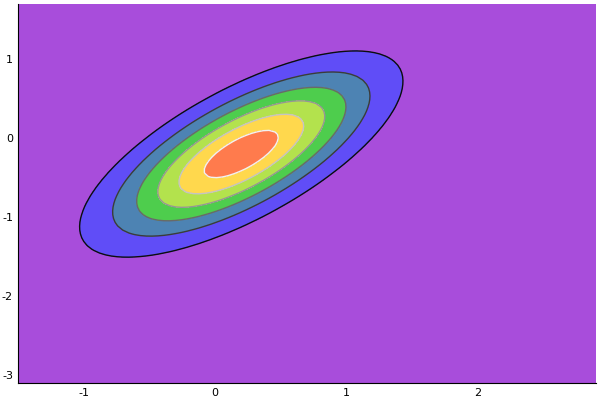

In [1]:
#=

@author : Spencer Lyon <spencer.lyon@nyu.edu>
          Victoria Gregory <victoria.gregory@nyu.edu>

=#
using Plots
pyplot()
using LaTeXStrings


function bivariate_normal(X::Matrix,
                          Y::Matrix,
                          σ_x::Real=1.0,
                          σ_y::Real=1.0,
                          μ_x::Real=0.0,
                          μ_y::Real=0.0,
                          σ_xy::Real=0.0)
    Xμ = X .- μ_x
    Yμ = Y .- μ_y

    ρ = σ_xy / (σ_x * σ_y)
    z = Xμ.^2 / σ_x^2 + Yμ.^2 / σ_y^2 - 2 * ρ .* Xμ .* Yμ / (σ_x * σ_y)
    denom = 2π * σ_x * σ_y * sqrt(1 - ρ^2)
    return exp.(-z / (2 * (1 - ρ^2))) ./ denom
end


# == Set up the Gaussian prior density p == #
Σ = [0.4  0.3
     0.3 0.45]
x_hat = [ 0.2
         -0.2]''

# == Define the matrices G and R from the equation y = G x + N(0, R) == #
G = eye(2)
R = 0.5 .* Σ

# == The matrices A and Q == #
A = [1.2    0
     0   -0.2]
Q = 0.3 .* Σ

# == The observed value of y == #
y = [2.3, -1.9]''

# == Set up grid for plotting == #
x_grid = linspace(-1.5, 2.9, 100)
y_grid = linspace(-3.1, 1.7, 100)
X=repmat(x_grid', length(y_grid), 1)
Y=repmat(y_grid, 1, length(y_grid))

function gen_gaussian_plot_vals(μ, C)
    "Z values for plotting the bivariate Gaussian N(μ, C)"
    m_x, m_y = μ[1], μ[2]
    s_x, s_y = sqrt(C[1, 1]), sqrt(C[2, 2])
    s_xy = C[1, 2]
    return bivariate_normal(X, Y, s_x, s_y, m_x, m_y, s_xy)
end

# == Plot the figure == #
Z = gen_gaussian_plot_vals(x_hat, Σ)
contour(x_grid, y_grid, Z, fill=true, levels=6, color=:lightrainbow, alpha=0.6)
contour!(x_grid, y_grid, Z, fill=false, levels=6, color=:grays, cbar=false)

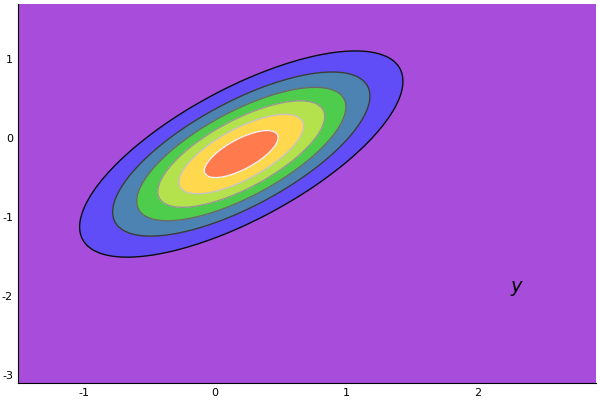

In [2]:
# == Plot the figure == #
Z = gen_gaussian_plot_vals(x_hat, Σ)
contour(x_grid, y_grid, Z, fill=true, levels=6, color=:lightrainbow, alpha=0.6)
contour!(x_grid, y_grid, Z, fill=false, levels=6, color=:grays, cbar=false)
annotate!(y[1], y[2], L"$y$", color=:black)

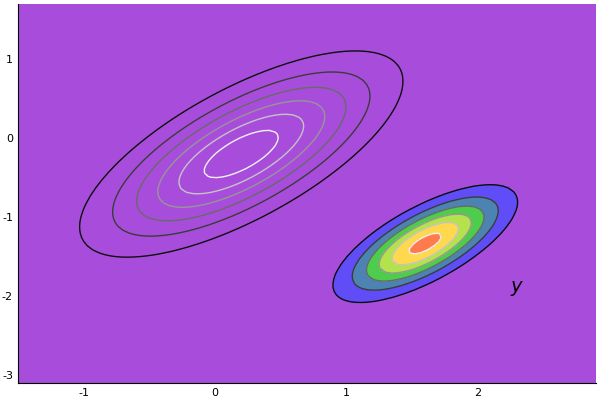

In [3]:
# == Plot the figure == #
Z = gen_gaussian_plot_vals(x_hat, Σ)
M = Σ * G' * inv(G * Σ * G' + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
new_Z = gen_gaussian_plot_vals(x_hat_F, Σ_F)
# Plot Density 1
contour(x_grid, y_grid, new_Z, fill=true, levels=6, color=:lightrainbow, alpha=0.6)
contour!(x_grid, y_grid, new_Z, fill=false, levels=6, color=:grays, cbar=false)
# Plot Density 2
contour!(x_grid, y_grid, Z, fill=false, levels=6, color=:grays, cbar=false)
annotate!(y[1], y[2], L"$y$", color=:black)

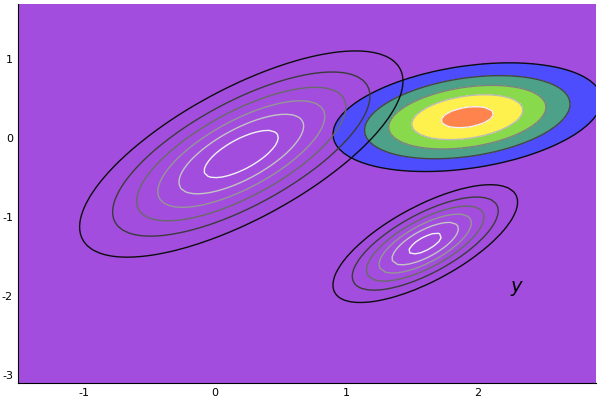

In [4]:
# == Plot the figure == #
Z = gen_gaussian_plot_vals(x_hat, Σ)
M = Σ * G' * inv(G * Σ * G' + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A' + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
# Plot Density 1
contour(x_grid, y_grid, new_Z, fill=true, levels=6, color=:lightrainbow, alpha=0.6)
contour!(x_grid, y_grid, new_Z, fill=false, levels=6, color=:grays, cbar=false)
# Plot Density 2
contour!(x_grid, y_grid, Z, fill=false, levels=6, color=:grays, cbar=false)
# Plot Density 3
contour!(x_grid, y_grid, Z_F, fill=false, levels=6, color=:grays, cbar=false)
annotate!(y[1], y[2], L"$y$", color=:black)

In [5]:
using QuantEcon

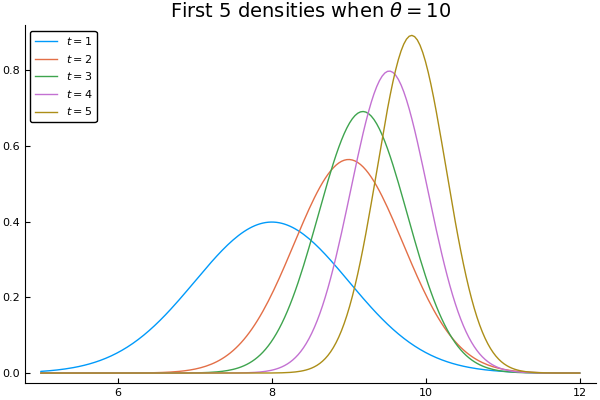

In [6]:
import Distributions: Normal, pdf
# == Parameters == #

θ = 10
A, G, Q, R = 1.0, 1.0, 0.0, 1.0
x_hat_0, Σ_0 = 8.0, 1.0

# == Initialize Kalman filter == #

kalman = Kalman(A, G, Q, R)
set_state!(kalman, x_hat_0, Σ_0)
# == Run == #

N = 5
xgrid = linspace(θ - 5, θ + 2, 200)
densities = []
labels = []
for i=1:N
    # Record the current predicted mean and variance, and plot their densities
    m, v = kalman.cur_x_hat, kalman.cur_sigma
    push!(densities, pdf.(Normal(m, sqrt(v)), xgrid))
    push!(labels, LaTeXString("\$t=$i\$"))

    # Generate the noisy signal
    y = θ + randn()

    # Update the Kalman filter
    update!(kalman, y)
end

plot(xgrid, densities, label=reshape(labels,1,length(labels)), legend=:topleft, grid=false,
     title=LaTeXString("First $N densities when \$θ = $θ\$"))

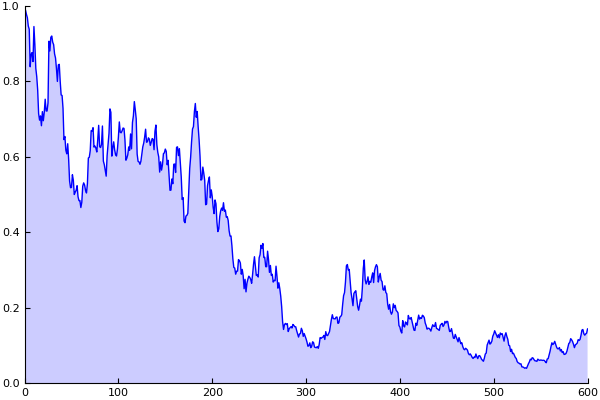

In [7]:
srand(42)  # reproducible results
ϵ = 0.1
kalman = Kalman(A, G, Q, R)
set_state!(kalman, x_hat_0, Σ_0)

nodes, weights = qnwlege(21, θ-ϵ, θ+ϵ)

T = 600
z = Array{Float64}(T)
for t=1:T
    # Record the current predicted mean and variance, and plot their densities
    m, v = kalman.cur_x_hat, kalman.cur_sigma
    dist = Normal(m, sqrt(v))
    integral = do_quad((x)->pdf.(dist, x), nodes, weights)
    z[t] = 1. - integral
    # Generate the noisy signal and update the Kalman filter
    update!(kalman, θ + randn())
end

plot(1:T, z, fillrange=0, color=:blue, fillalpha=0.2, grid=false,
     legend=false, xlims=(0, T), ylims=(0, 1))

Eigenvalues of A:
[0.9, -0.1]
Stationary prediction error variance:
[0.403291 0.105072; 0.105072 0.410617]


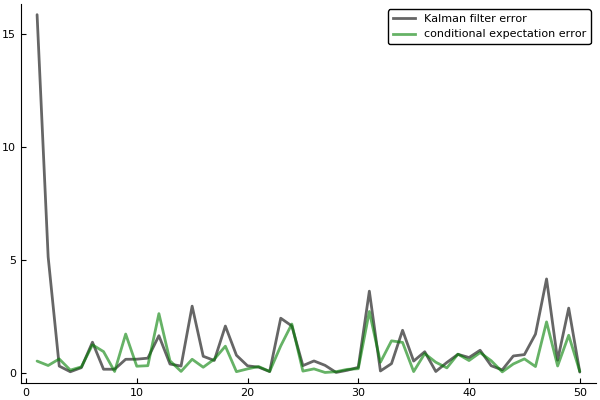

In [12]:
import Distributions: MultivariateNormal, rand
srand(41)  # reproducible results

# === Define A, Q, G, R === #
G = eye(2)
R = 0.5 .* G
A = [0.5 0.4
     0.6 0.3]
Q = 0.3 .* G

# === Define the prior density === #
Σ = [0.9 0.3
     0.3 0.9]
x_hat = [8, 8]''

# === Initialize the Kalman filter === #
kn = Kalman(A, G, Q, R)
set_state!(kn, x_hat, Σ)

# === Set the true initial value of the state === #
x = zeros(2)

# == Print eigenvalues of A == #
println("Eigenvalues of A:\n$(eigvals(A))")

# == Print stationary Σ == #
S, K = stationary_values(kn)
println("Stationary prediction error variance:\n$S")

# === Generate the plot === #
T = 50
e1 = Array{Float64}(T)
e2 = Array{Float64}(T)
for t=1:T
    # == Generate signal and update prediction == #
    dist = MultivariateNormal(G*x, R)
    y = rand(dist)
    update!(kn, y)

    # == Update state and record error == #
    Ax = A * x
    x = rand(MultivariateNormal(Ax, Q))
    e1[t] = sum((x - kn.cur_x_hat).^2)
    e2[t] = sum((x - Ax).^2)
end

plot(1:T, e1, color=:black, linewidth=2, alpha=0.6, label="Kalman filter error", grid=false)
plot!(1:T, e2, color=:green, linewidth=2, alpha=0.6, label="conditional expectation error")

```none
Eigenvalues of A:
[0.9,-0.1]
Stationary prediction error variance:
[0.403291 0.105072; 0.105072 0.410617]
```
